# Invasive Ductal Cancer

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image as Image

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

2021-11-23 18:44:55.473532: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-23 18:44:55.473602: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Running locally
X = np.load('../idc/data/X.npy')
y = np.load('../idc/data/Y.npy')

## Baseline CNN Model

In [3]:
X_scaled = X/255

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=1)

In [5]:
from tensorflow.keras import models
from tensorflow.keras import Sequential, layers

In [17]:
from keras.models import load_model

In [18]:
model = load_model('../models/model3.h5')

2021-11-23 18:44:58.565819: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-23 18:44:58.565866: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-23 18:44:58.565884: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-NEEV1SD): /proc/driver/nvidia/version does not exist
2021-11-23 18:44:58.566125: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
model.evaluate(X_test, y_test)

2021-11-23 18:44:59.110780: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-23 18:44:59.113143: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2112005000 Hz


44/44 [==============================] - 11s 9ms/step - loss: 0.4977 - accuracy: 0.7765 - recall: 0.7907 - precision: 0.7662


[0.49770587682724, 0.7764960527420044, 0.7906976938247681, 0.7661972045898438]

In [21]:
model.predict(X_test)

array([[0.34126264],
       [0.5611944 ],
       [0.5166884 ],
       ...,
       [0.9062021 ],
       [0.41598862],
       [0.9681145 ]], dtype=float32)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 49, 49, 16)        208       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 48, 48, 32)        2080      
_________________________________________________________________
flatten_2 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 73729     
Total params: 76,017
Trainable params: 76,017
Non-trainable params: 0
_________________________________________________________________


In [24]:
img_size = (50, 50)
last_conv_layer_name = "conv2d_5"

In [26]:
from IPython.display import Image, display

# Kinda dont need a get_img_array 
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [28]:
img_array = np.expand_dims(X_train[5],0)

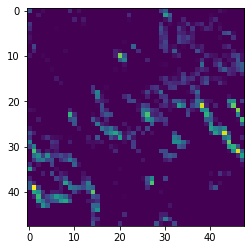

In [29]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None)
plt.imshow(heatmap);

In [30]:
from IPython.display import Image, display

def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.9):
    # Load the original image
#     img = keras.preprocessing.image.load_img(img_path)
#     img = keras.preprocessing.image.img_to_array(img)
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    
    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
#     superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img
    # Save the superimposed image
#     superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))


something = save_and_display_gradcam(X_train[5], heatmap) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


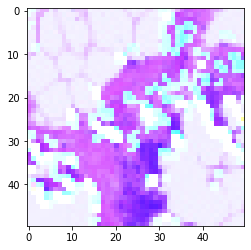

In [31]:
plt.imshow(something);

In [ ]:
plt.imshow(X_train[5]);